In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
river_dl = np.load("../../../Downloads/prepped2.npz", allow_pickle = True)

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

ajd_matrix = river_dl['dist_matrix']
batch_size = ajd_matrix.shape[0]

x.shape, y.shape, ajd_matrix.shape

(torch.Size([455, 365, 16]), torch.Size([455, 365, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        f_seq = []
        o_seq = []
        q_seq = []
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            f_seq.append(f_t.unsqueeze(1))
            o_seq.append(o_t.unsqueeze(1))
            q_seq.append(q_t.unsqueeze(1))
            hidden_seq.append(h_t.unsqueeze(1))
        f_seq = torch.cat(f_seq, dim=1)
        o_seq = torch.cat(o_seq, dim=1)
        q_seq = torch.cat(q_seq, dim=1)
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out, (f_seq, o_seq, q_seq, hidden_seq)
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(16, 20, ajd_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

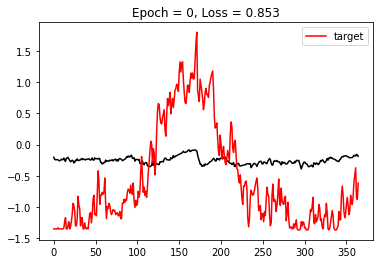

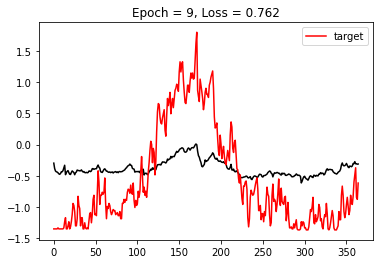

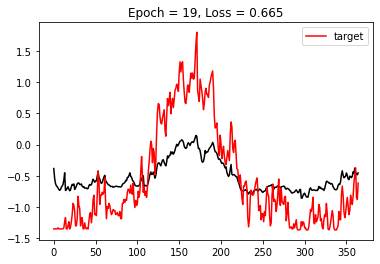

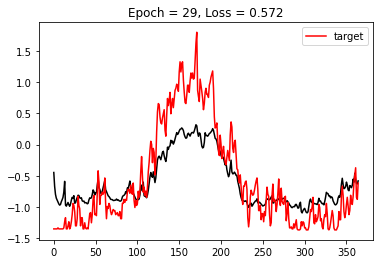

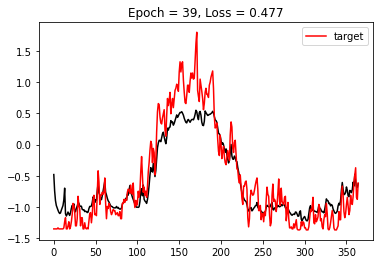

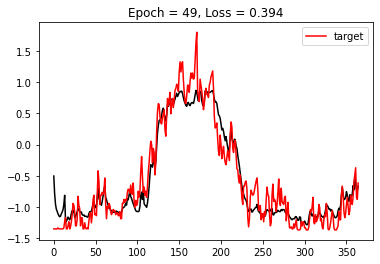

In [6]:
epochs = 50

for i in range(epochs):
    out, (f_ls, o_ls, q_ls, h_ls) = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Apply XAI and visualize

In [7]:
f_ls = f_ls.detach()
o_ls = o_ls.detach()
q_ls = q_ls.detach()
h_ls = h_ls.detach()

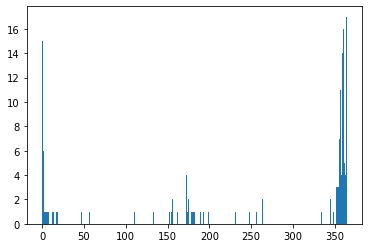

In [8]:
num_nan = []
for i in range(455):
    num_nan.append(np.sum(np.isnan(y.numpy()[i])))
num_nan = np.asarray(num_nan)
plt.hist(num_nan, bins = range(365));

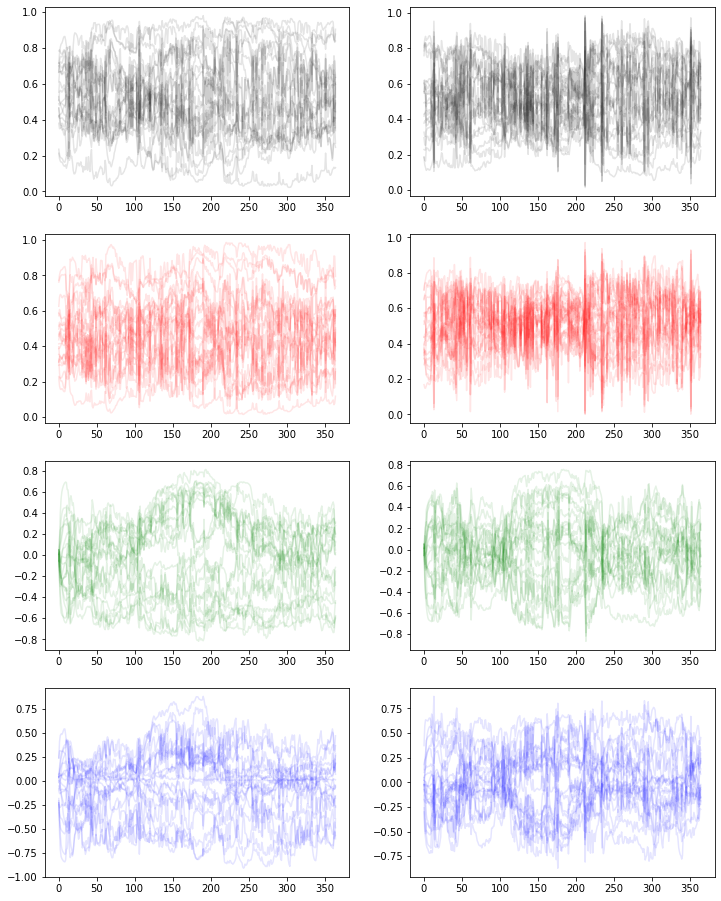

In [9]:
fig, ax = plt.subplots(4, 2, figsize = (12, 16))

most_data_i = np.random.choice(np.arange(455)[num_nan < 180])
few_data_i = np.random.choice(np.arange(455)[num_nan >= 180])

ax[0, 0].plot(f_ls[few_data_i, :], color = 'black', alpha = 0.1)
ax[1, 0].plot(o_ls[few_data_i, :], color = 'red', alpha = 0.1)
ax[2, 0].plot(q_ls[few_data_i, :], color = 'green', alpha = 0.1)
ax[3, 0].plot(h_ls[few_data_i, :], color = 'blue', alpha = 0.1)

ax[0, 1].plot(f_ls[most_data_i, :], color = 'black', alpha = 0.1)
ax[1, 1].plot(o_ls[most_data_i, :], color = 'red', alpha = 0.1)
ax[2, 1].plot(q_ls[most_data_i, :], color = 'green', alpha = 0.1)
ax[3, 1].plot(h_ls[most_data_i, :], color = 'blue', alpha = 0.1);

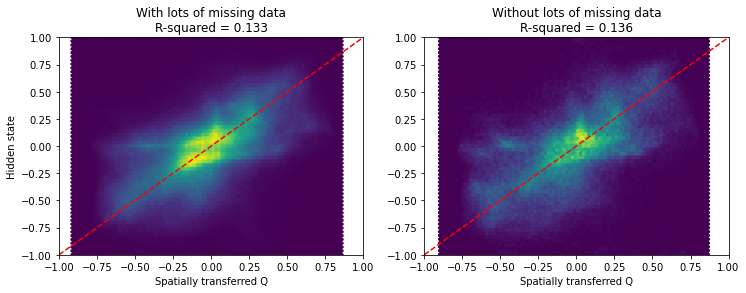

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

most_data_q_ls = q_ls[np.arange(455)[num_nan < 180]]
most_data_h_ls = h_ls[np.arange(455)[num_nan < 180]]

few_data_q_ls = q_ls[np.arange(455)[num_nan >= 180]]
few_data_h_ls = h_ls[np.arange(455)[num_nan >= 180]]

most_r2 = r2_score(most_data_q_ls.numpy().flatten(), most_data_h_ls.numpy().flatten())
few_r2 = r2_score(few_data_q_ls.numpy().flatten(), few_data_h_ls.numpy().flatten())

ax[0].hexbin(few_data_q_ls, few_data_h_ls)
ax[0].plot([-1, 1], [-1, 1], color = 'red', linestyle = '--')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].set_title('With lots of missing data\nR-squared = ' + str(np.round(few_r2, 3)))
ax[0].set_ylabel('Hidden state')
ax[0].set_xlabel('Spatially transferred Q')

ax[1].hexbin(most_data_q_ls, most_data_h_ls)
ax[1].plot([-1, 1], [-1, 1], color = 'red', linestyle = '--')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_title('Without lots of missing data\nR-squared = ' + str(np.round(most_r2, 3)))
ax[1].set_xlabel('Spatially transferred Q');

In [22]:
most_r2_ls = []
few_r2_ls = []

# For varying how exclusive we are about what a segment with
# mostly NaN-free data is, examine how r-squared changes
    # do more data-rich segments rely more or less on their neighbors information
    # than a data-sparse segment
for i in range(1, 180):
    most_data_q_ls = q_ls[np.arange(455)[num_nan < i]]
    most_data_h_ls = h_ls[np.arange(455)[num_nan < i]]

    few_data_q_ls = q_ls[np.arange(455)[num_nan >= i]]
    few_data_h_ls = h_ls[np.arange(455)[num_nan >= i]]

    most_r2 = r2_score(most_data_q_ls.numpy().flatten(), most_data_h_ls.numpy().flatten())
    few_r2 = r2_score(few_data_q_ls.numpy().flatten(), few_data_h_ls.numpy().flatten())
    
    most_r2_ls.append(most_r2)
    few_r2_ls.append(few_r2)

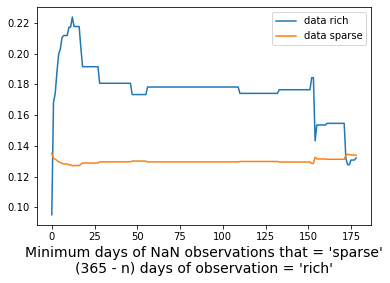

In [34]:
plt.plot(most_r2_ls, label = 'data rich')
plt.plot(few_r2_ls, label = 'data sparse')
plt.legend()
plt.xlabel("Minimum days of NaN observations that = 'sparse'\n(365 - n) days of observation = 'rich'",
           fontsize = 14);

It would appear that more observations allows the model to learn how to use its neighborhood information better - rather than fewer observations necessitating the use of neighborhood information, the model perhaps doesn't learn how to use the neighborhood information for sparsely observed segments